# Load required packages

In [1]:
import numpy as np
import scanpy as sc
import h5py
import warnings
warnings.filterwarnings('ignore')
from scbig import run_scbig, setup_seed

Using backend: pytorch


# Read data

In [2]:
# This data could be downloaded from https://drive.google.com/drive/folders/1JX589QWH7N895cAMAdJR9KDaFEigy1r3
setup_seed(100)
data_mat = h5py.File('Human_pancreatic_islets.h5')
X = np.array(data_mat['X']).astype(np.int_)
Y = np.array(data_mat['Y']).astype(np.int_).squeeze()
data_mat.close()
adata = sc.AnnData(X.astype('float'))
adata.obs['cl_type'] = Y
print("Sparsity: ", np.where(adata.X == 0)[0].shape[0] / (adata.X.shape[0] * adata.X.shape[1]))
print(adata)

Sparsity:  0.9058902739548357
AnnData object with n_obs × n_vars = 1724 × 20125
    obs: 'cl_type'


# Perform data pre-processing

In [3]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
adata.raw = adata.copy()
sc.pp.normalize_per_cell(adata)
adata.obs['cs_factor'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
sc.pp.log1p(adata)
adata.var['gs_factor'] = np.max(adata.X, axis=0, keepdims=True).reshape(-1)

In [4]:
adata

AnnData object with n_obs × n_vars = 1724 × 14884
    obs: 'cl_type', 'n_genes', 'n_counts', 'cs_factor'
    var: 'n_cells', 'gs_factor'
    uns: 'log1p'

In [5]:
print("Sparsity of after preprocessing: ", np.where(adata.X == 0)[0].shape[0] / (adata.X.shape[0] * adata.X.shape[1]))
n_clusters = len(np.unique(Y))
print("number of cell type:{}".format(n_clusters))

Sparsity of after preprocessing:  0.8728283723595496
number of cell type:14


# Run scBiG

In default mode, function run_scbig would return an AnnData object with cell embedding stored in adata.obsm['feat'] and louvain clustering result stored in adata.obs['louvain']

In addition, function run_scbig would print and return all results during each logging training:
- all_loss: loss of training
- ari_k: ARI of KMeans
- ari_l: ARI of Louvain
- nmi_k: NMI of KMeans
- nmi_l: NMI of Louvain

In [6]:
adata, record = run_scbig(adata, cl_type='cl_type', return_all=True)

Start training on cpu...
[5/200-iter] | [train] exp loss : 2.3417, unexp loss : 0.4071
[10/200-iter] | [train] exp loss : 1.8244, unexp loss : 0.4183
[15/200-iter] | [train] exp loss : 1.7638, unexp loss : 0.3556
[20/200-iter] | [train] exp loss : 1.7018, unexp loss : 0.3661
[25/200-iter] | [train] exp loss : 1.6665, unexp loss : 0.3763
Number of clusters identified by Louvain is 11
Clustering Kmeans 25: NMI= 0.6299, ARI= 0.3811
Clustering Louvain 25: NMI= 0.6918, ARI= 0.5599
[30/200-iter] | [train] exp loss : 1.6693, unexp loss : 0.3556
[35/200-iter] | [train] exp loss : 1.6448, unexp loss : 0.3644
[40/200-iter] | [train] exp loss : 1.6406, unexp loss : 0.3574
[45/200-iter] | [train] exp loss : 1.6284, unexp loss : 0.3578
[50/200-iter] | [train] exp loss : 1.6242, unexp loss : 0.3536
Number of clusters identified by Louvain is 9
Clustering Kmeans 50: NMI= 0.7369, ARI= 0.4868
Clustering Louvain 50: NMI= 0.8490, ARI= 0.8439
[55/200-iter] | [train] exp loss : 1.6184, unexp loss : 0.3508


In [7]:
adata

AnnData object with n_obs × n_vars = 1724 × 14884
    obs: 'cl_type', 'n_genes', 'n_counts', 'cs_factor', 'kmeans', 'louvain'
    var: 'n_cells', 'gs_factor'
    uns: 'log1p', 'neighbors', 'louvain'
    obsm: 'e0', 'e2', 'feat'
    varm: 'feat'
    obsp: 'distances', 'connectivities'

# Visualization

## Show clustering results

In [8]:
# Use cell embedding `feat` to perfrom Umap
sc.tl.umap(adata)

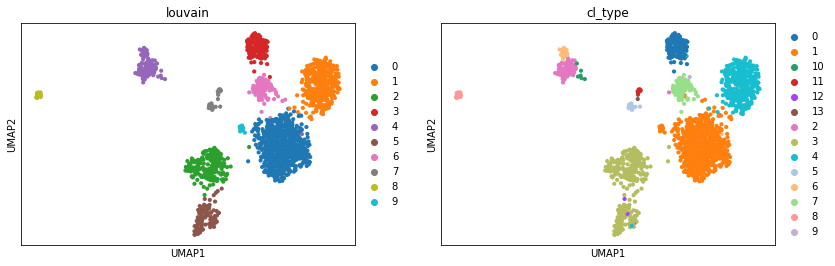

In [9]:
adata.obs['cl_type'] = adata.obs['cl_type'].astype(str).astype('category')
adata.obs['louvain'] = adata.obs['louvain'].astype(str).astype('category')
sc.pl.umap(adata, color=['louvain', 'cl_type'])